# Structured data classification from scratch

This tutorial is based on:

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/06/09<br>
**Last modified:** 2020/06/09<br>
**Description:** Binary classification of structured data including numerical and categorical features.

This example demonstrates how to do structured data classification, starting from a raw
CSV file. Our data includes both numerical and categorical features. We will use Keras
preprocessing layers to normalize the numerical features and vectorize the categorical
ones.

Note that this example should be run with TensorFlow 2.5 or higher.

[Our dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) is provided by the
Cleveland Clinic Foundation for Heart Disease.
It's a CSV file with 303 rows. Each row contains information about a patient (a
**sample**), and each column describes an attribute of the patient (a **feature**). We
use the features to predict whether a patient has a heart disease (**binary
classification**).

Here's the description of each feature:

Column| Description| Feature Type
------------|--------------------|----------------------
Age | Age in years | Numerical
Sex | (1 = male; 0 = female) | Categorical
CP | Chest pain type (0, 1, 2, 3, 4) | Categorical
Trestbpd | Resting blood pressure (in mm Hg on admission) | Numerical
Chol | Serum cholesterol in mg/dl | Numerical
FBS | fasting blood sugar in 120 mg/dl (1 = true; 0 = false) | Categorical
RestECG | Resting electrocardiogram results (0, 1, 2) | Categorical
Thalach | Maximum heart rate achieved | Numerical
Exang | Exercise induced angina (1 = yes; 0 = no) | Categorical
Oldpeak | ST depression induced by exercise relative to rest | Numerical
Slope | Slope of the peak exercise ST segment | Numerical
CA | Number of major vessels (0-3) colored by fluoroscopy | Both numerical & categorical
Thal | 3 = normal; 6 = fixed defect; 7 = reversible defect | Categorical
Target | Diagnosis of heart disease (1 = true; 0 = false) | Target

## Setup

In [16]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

## Preparing the data


### Import
Let's download the data and load it into a Pandas dataframe:

In [17]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

In [18]:
dataframe.shape

(303, 14)

The dataset includes 303 samples with 14 columns per sample (13 features, plus the target
label):

Here's a preview of a few samples:

In [19]:
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


The last column, "target", indicates whether the patient has a heart disease (1) or not
(0).

## Data splitting

Let's split the data into a training and validation set:

In [20]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)

Using 242 samples for training and 61 for validation


### Transform to Tensors

The [tf.data.Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) supports writing descriptive and efficient input pipelines. Dataset usage follows a common pattern:

- Create a source dataset from your input data.
- Apply dataset transformations to preprocess the data.
- Iterate over the dataset and process the elements.

In [21]:
# First, a simple example
example_dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
# Print tensor
for element in example_dataset:
  print(element)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)


In [22]:
# Example with dictionary
example_dataset = tf.data.Dataset.from_tensor_slices({"a":[1, 2], "b":[10, 11]} )
# Print tensor
for element in example_dataset:
  print(element)

{'a': <tf.Tensor: shape=(), dtype=int32, numpy=1>, 'b': <tf.Tensor: shape=(), dtype=int32, numpy=10>}
{'a': <tf.Tensor: shape=(), dtype=int32, numpy=2>, 'b': <tf.Tensor: shape=(), dtype=int32, numpy=11>}


In [23]:
# How to use dictionary in combination with pandas dataframe 
# We only use 1 patients
example_dataset = tf.data.Dataset.from_tensor_slices(dict(dataframe[0:1]))

for element in example_dataset:
  print(element)

{'age': <tf.Tensor: shape=(), dtype=int64, numpy=63>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=233>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=150>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=2.3>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'fixed'>, 'target': <tf.Tensor: shape=(), dtype=int64, numpy=0>}


Let's generate [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects for our training and validation dataframes:

In [24]:
# Define a function to create our tensors
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [25]:
# Use function
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

Each `Dataset` yields a tuple `(input, target)` where `input` is a dictionary of features
and `target` is the value `0` or `1`:

In [26]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print(50*"-")    
    print("Target:", y)

Input: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=62>, 'sex': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'trestbps': <tf.Tensor: shape=(), dtype=int64, numpy=160>, 'chol': <tf.Tensor: shape=(), dtype=int64, numpy=164>, 'fbs': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'restecg': <tf.Tensor: shape=(), dtype=int64, numpy=2>, 'thalach': <tf.Tensor: shape=(), dtype=int64, numpy=145>, 'exang': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'oldpeak': <tf.Tensor: shape=(), dtype=float64, numpy=6.2>, 'slope': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'ca': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'thal': <tf.Tensor: shape=(), dtype=string, numpy=b'reversible'>}
--------------------------------------------------
Target: tf.Tensor(1, shape=(), dtype=int64)


### Create batches

Let's batch the datasets (combine some of our samples). Here, we use a mini-batch size of 32:

In [27]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)

In [28]:
train_ds

<BatchDataset shapes: ({age: (None,), sex: (None,), cp: (None,), trestbps: (None,), chol: (None,), fbs: (None,), restecg: (None,), thalach: (None,), exang: (None,), oldpeak: (None,), slope: (None,), ca: (None,), thal: (None,)}, (None,)), types: ({age: tf.int64, sex: tf.int64, cp: tf.int64, trestbps: tf.int64, chol: tf.int64, fbs: tf.int64, restecg: tf.int64, thalach: tf.int64, exang: tf.int64, oldpeak: tf.float64, slope: tf.int64, ca: tf.int64, thal: tf.string}, tf.int64)>

## Feature preprocessing with Keras layers

Next, we perform feature preprocessing with Keras layers. 

### Categorical features

The following features are *categorical features* encoded as integers:

- `sex`
- `cp`
- `fbs`
- `restecg`
- `exang`
- `ca`

We will encode these features using **one-hot encoding**. We have two options
here:

 - Use [`CategoryEncoding()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CategoryEncoding), which requires knowing the range of input values
 and will error on input outside the range.
 - Use [`IntegerLookup()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup) which will build a lookup table for inputs and reserve
 an output index for unkown input values.

For this example, we want a simple solution that will handle out of range inputs
at inference, so we will use `IntegerLookup()`.

We also have a categorical feature encoded as a *string*: `thal`. We will create an
index of all possible features and encode output using the `StringLookup()` layer.

### Numeric features

Finally, the following feature are continuous *numerical* features:

- `age`
- `trestbps`
- `chol`
- `thalach`
- `oldpeak`
- `slope`

For each of these features, we will use a [`Normalization()`](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/) layer to make sure the mean
of each feature is 0 and its standard deviation is 1.

### Preprocessing functions

Below, we define utility functions to do the feature preprocessing operations:

- `encode_numerical_feature` to apply featurewise normalization to numerical features.

In [30]:
from tensorflow.keras.layers import Normalization

# Define numerical preprocessing function
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

- `encode_string_categorical_feature` to first turn string inputs into integer indices,
then one-hot encode these integer indices.
- `encode_integer_categorical_feature` to one-hot encode integer categorical features.

We use [tf.expand_dims(input, axis, name=None)](https://www.tensorflow.org/api_docs/python/tf/expand_dims) to return a tensor with a length 1 axis inserted at index axis `-1`. A negative axis counts from the end so `axis=-1` adds an inner most dimension.

During [adapt()](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/), the layer will analyze a data set, determine the frequency of individual strings tokens, and create a vocabulary from them. If the vocabulary is capped in size, the most frequent tokens will be used to create the vocabulary and all others will be treated as out-of-vocabulary (OOV).

In [31]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import StringLookup

# Define categorical preprocessing function
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


## Build a model

With this done, we can create our end-to-end model:

1) Define keras.Input for every feature: 

In [32]:
# Categorical features encoded as integers
sex = keras.Input(shape=(1,), name="sex", dtype="int64")
cp = keras.Input(shape=(1,), name="cp", dtype="int64")
fbs = keras.Input(shape=(1,), name="fbs", dtype="int64")
restecg = keras.Input(shape=(1,), name="restecg", dtype="int64")
exang = keras.Input(shape=(1,), name="exang", dtype="int64")
ca = keras.Input(shape=(1,), name="ca", dtype="int64")

# Categorical feature encoded as string
thal = keras.Input(shape=(1,), name="thal", dtype="string")

# Numerical features
age = keras.Input(shape=(1,), name="age")
trestbps = keras.Input(shape=(1,), name="trestbps")
chol = keras.Input(shape=(1,), name="chol")
thalach = keras.Input(shape=(1,), name="thalach")
oldpeak = keras.Input(shape=(1,), name="oldpeak")
slope = keras.Input(shape=(1,), name="slope")


2) Make a list of all keras.Input feature names

In [33]:
all_inputs = [
    sex,
    cp,
    fbs,
    restecg,
    exang,
    ca,
    thal,
    age,
    trestbps,
    chol,
    thalach,
    oldpeak,
    slope,
]

3) Perform preprocessing

In [34]:
# Integer categorical features
sex_encoded = encode_categorical_feature(sex, "sex", train_ds, False)
cp_encoded = encode_categorical_feature(cp, "cp", train_ds, False)
fbs_encoded = encode_categorical_feature(fbs, "fbs", train_ds, False)
restecg_encoded = encode_categorical_feature(restecg, "restecg", train_ds, False)
exang_encoded = encode_categorical_feature(exang, "exang", train_ds, False)
ca_encoded = encode_categorical_feature(ca, "ca", train_ds, False)

# String categorical features
thal_encoded = encode_categorical_feature(thal, "thal", train_ds, True)

# Numerical features
age_encoded = encode_numerical_feature(age, "age", train_ds)
trestbps_encoded = encode_numerical_feature(trestbps, "trestbps", train_ds)
chol_encoded = encode_numerical_feature(chol, "chol", train_ds)
thalach_encoded = encode_numerical_feature(thalach, "thalach", train_ds)
oldpeak_encoded = encode_numerical_feature(oldpeak, "oldpeak", train_ds)
slope_encoded = encode_numerical_feature(slope, "slope", train_ds)

all_features = layers.concatenate(
    [
        sex_encoded,
        cp_encoded,
        fbs_encoded,
        restecg_encoded,
        exang_encoded,
        slope_encoded,
        ca_encoded,
        thal_encoded,
        age_encoded,
        trestbps_encoded,
        chol_encoded,
        thalach_encoded,
        oldpeak_encoded,
    ]
)

2) Build the model 

1. We use 32 number of units in the first layer
1. We use [layers.Dropout()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) to prevent overvitting
1. Our output layer has 1 output (since the classification task is binary)
1. keras.Model groups layers into an object with training and inference features.


In [35]:
# 1
x = layers.Dense(32, activation="relu")(all_features)
# 2
x = layers.Dropout(0.5)(x)
# 3
output = layers.Dense(1, activation="sigmoid")(x)
# 4
model = keras.Model(all_inputs, output)


[Model.compile](https://keras.io/api/models/model_training_apis/) configures the model for training:

- [Optimizer](https://keras.io/api/optimizers/): one common option for the optimizer is [Adam](https://keras.io/api/optimizers/adam/),a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
- [loss](https://keras.io/api/losses/): The purpose of loss functions is to compute the quantity that a model should seek to minimize during training. 
- [metrics](https://keras.io/api/metrics/): A metric is a function that is used to judge the performance of your model.


In [36]:
model.compile(optimizer="adam", 
              loss ="binary_crossentropy", 
              metrics=["accuracy"])

Let's visualize our connectivity graph:

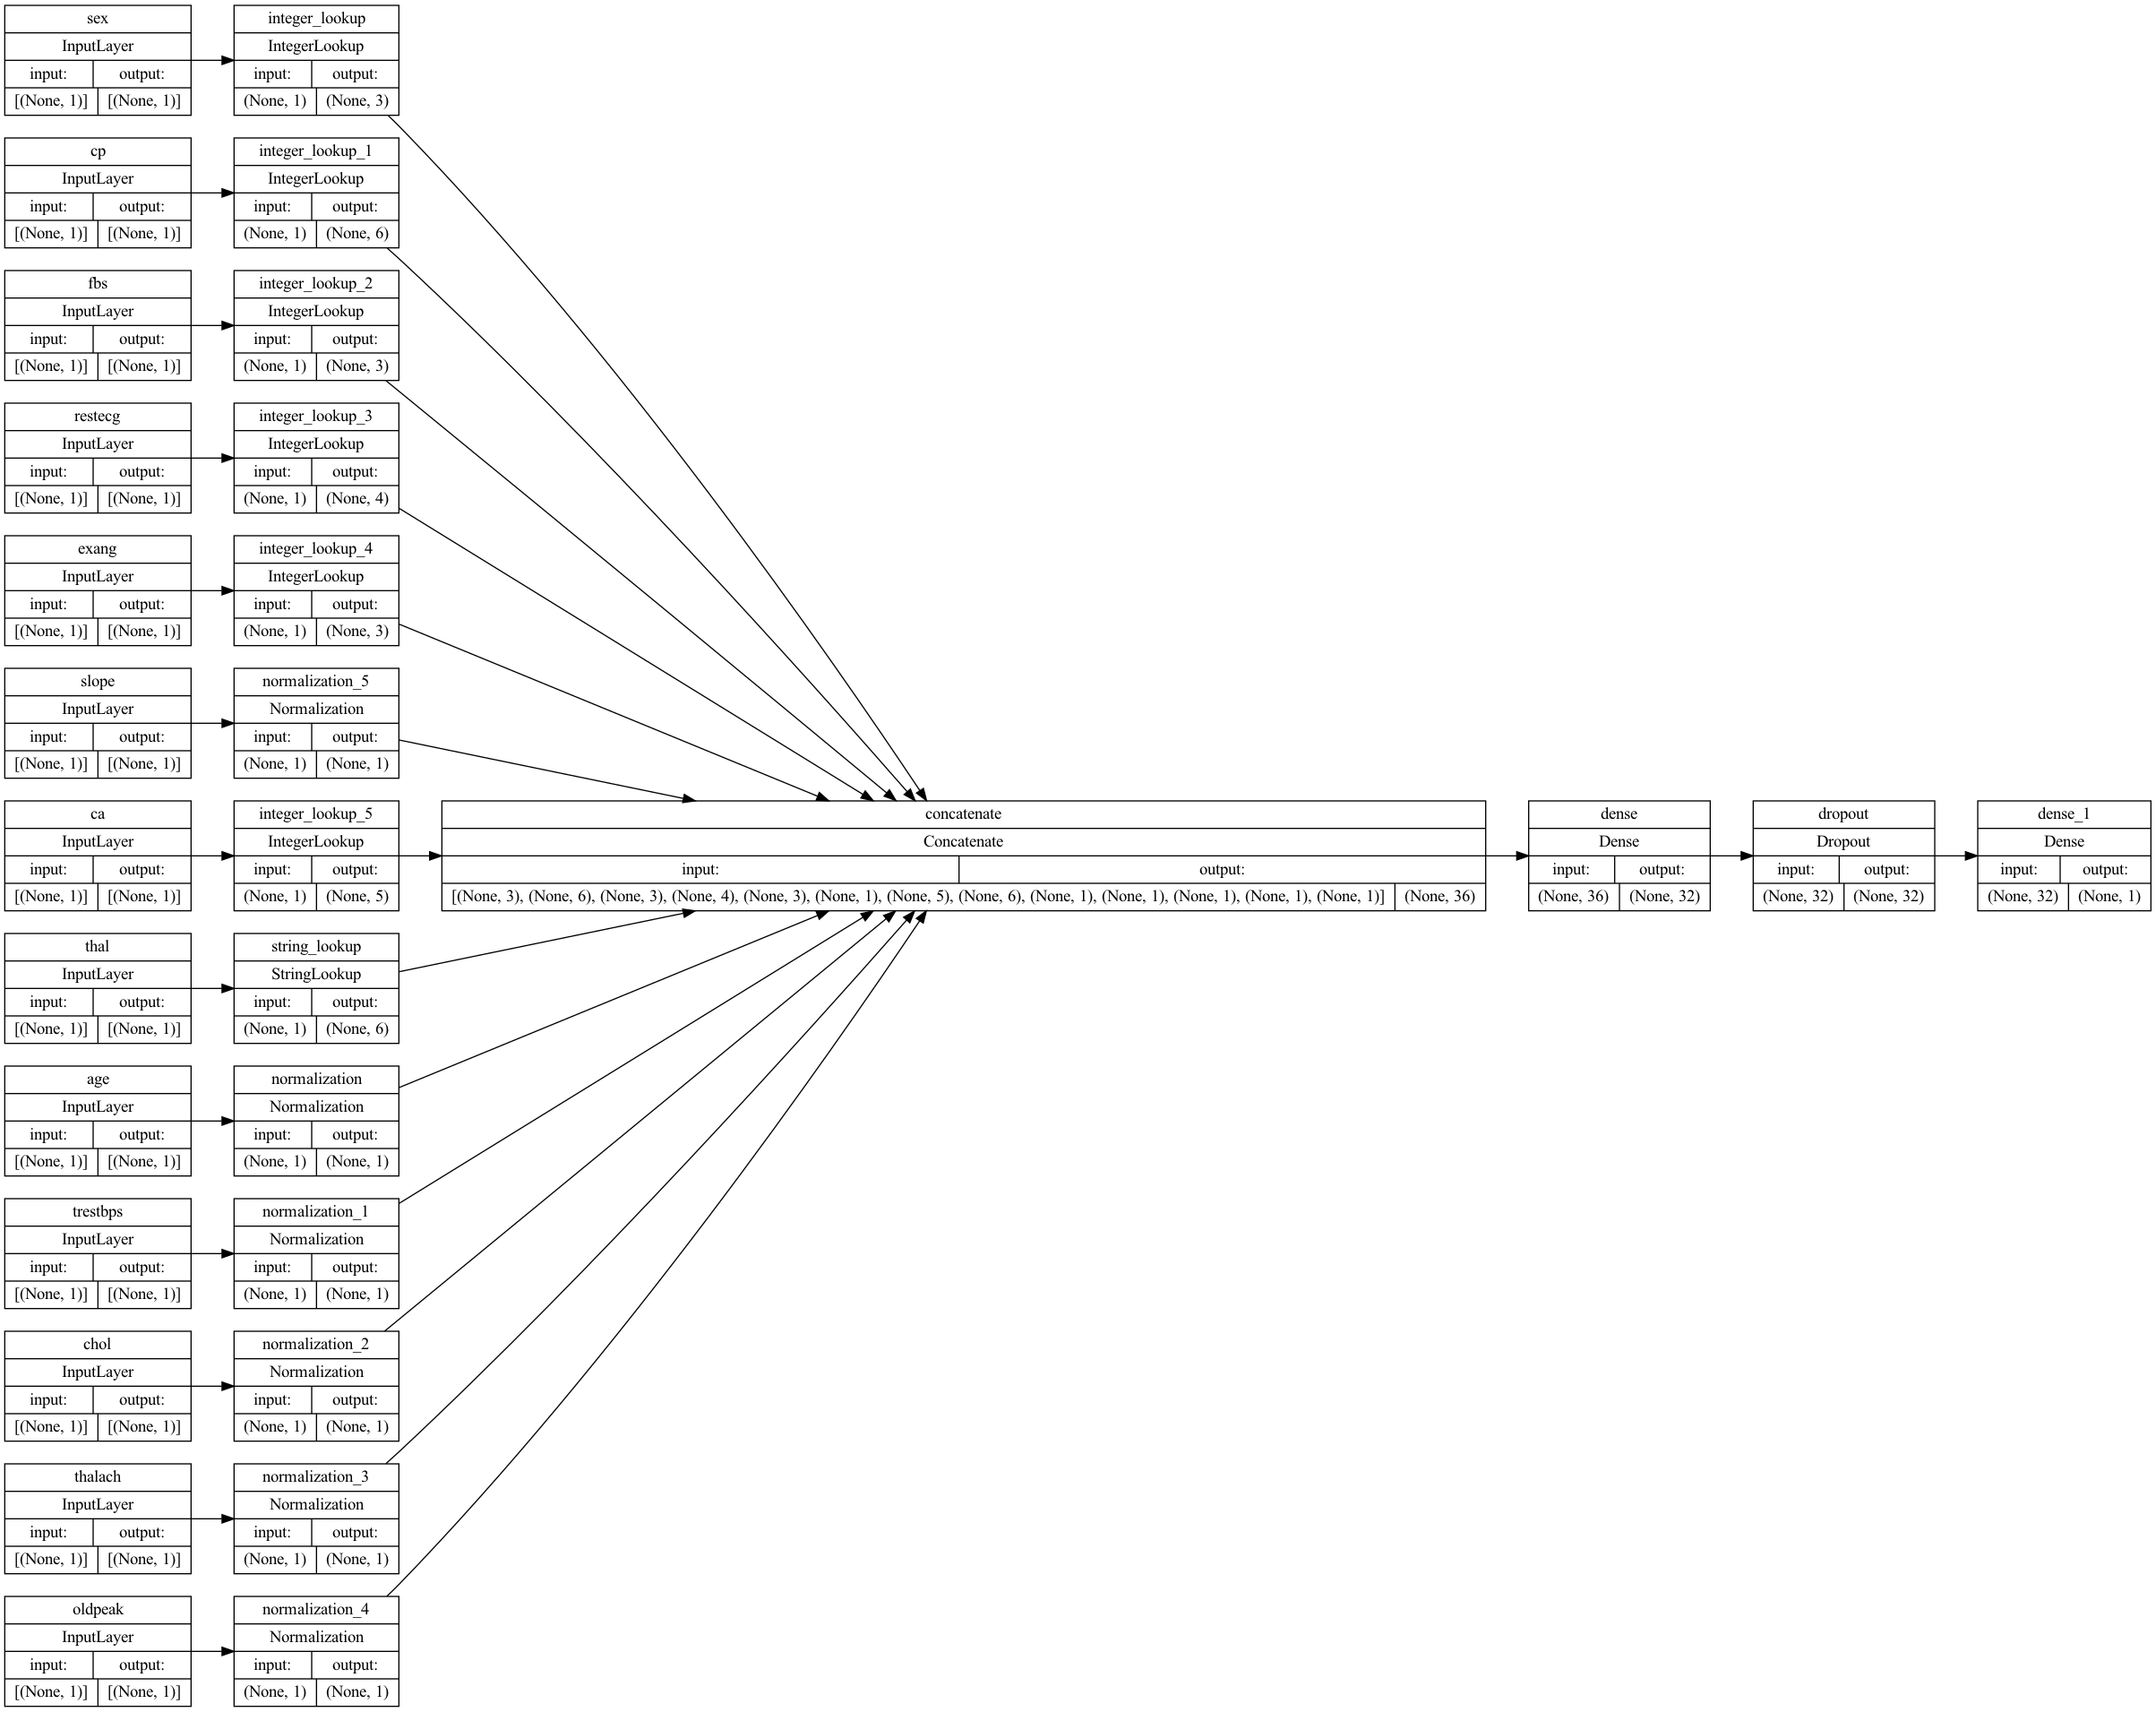

In [37]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Train the model

Trains the model for a fixed number of epochs (iterations on a dataset).

An epoch is an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation. Here, we only use 10 epochs.

In [38]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
8/8 [==============================] - 1s 46ms/step - loss: 0.7196 - accuracy: 0.5496 - val_loss: 0.5986 - val_accuracy: 0.7213
Epoch 2/10
8/8 [==============================] - 0s 7ms/step - loss: 0.6296 - accuracy: 0.6736 - val_loss: 0.5570 - val_accuracy: 0.7377
Epoch 3/10
8/8 [==============================] - 0s 10ms/step - loss: 0.6444 - accuracy: 0.6446 - val_loss: 0.5237 - val_accuracy: 0.7377
Epoch 4/10
8/8 [==============================] - 0s 9ms/step - loss: 0.5583 - accuracy: 0.7314 - val_loss: 0.4965 - val_accuracy: 0.7213
Epoch 5/10
8/8 [==============================] - 0s 11ms/step - loss: 0.5568 - accuracy: 0.7107 - val_loss: 0.4754 - val_accuracy: 0.7541
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: 0.5119 - accuracy: 0.7273 - val_loss: 0.4568 - val_accuracy: 0.7541
Epoch 7/10
8/8 [==============================] - 0s 6ms/step - loss: 0.5025 - accuracy: 0.7397 - val_loss: 0.4426 - val_accuracy: 0.7705
Epoch 8/10
8/8 [==============

We quickly get to 80% validation accuracy.

## Inference on new data

To get a prediction for a new sample, you can simply call `model.predict()`. There are
just two things you need to do:

1. wrap scalars into a list so as to have a batch dimension (models only process batches
of data, not single samples)
2. Call `convert_to_tensor` on each feature

In [39]:
sample = {
    "age": 60,
    "sex": 1,
    "cp": 1,
    "trestbps": 145,
    "chol": 233,
    "fbs": 1,
    "restecg": 2,
    "thalach": 150,
    "exang": 0,
    "oldpeak": 2.3,
    "slope": 3,
    "ca": 0,
    "thal": "fixed",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}

predictions = model.predict(input_dict)

print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)

This particular patient had a 40.5 percent probability of having a heart disease, as evaluated by our model.
